In [32]:
from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

from regression import log_likelihood_image
from optimize import quick_optimize_full_opt, quick_image_full_opt, quick_optimize_cent, quick_image_cent
from datetime import datetime

## Get the initial system parameters

In [33]:
import pandas

image_data = pandas.read_csv('image_info.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance"]
image_data = image_data.loc['hr4796a_H_pol']
print(image_data)

Radius            78.50
Inclination       76.50
Position Angle    26.10
Distance          72.78
Name: hr4796a_H_pol, dtype: float64


## Reading and Displaying Fits File

In [34]:
def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image


def create_empirical_err_map(data, annulus_width=5, mask_rad=9):    
    y,x = np.indices(data.shape)
    y -= data.shape[0]//2
    x -= data.shape[1]//2 
    radii = np.sqrt(x**2 + y**2) 
    noise_array = np.zeros_like(data)
    for i in range(0, int(np.max(radii)//annulus_width) ): 
        indices = (radii > i*annulus_width) & (radii <= (i+1)*annulus_width) 
        noise_array[indices] = np.nanstd(data[indices])
    mask = radii <= mask_rad
    noise_array[mask] = 0
    return noise_array

def get_inc_bounded_knots(inclination, num_knots, buffer = 2):
    
    knot_locations = jnp.linspace(jnp.cos(jnp.deg2rad(90-inclination-buffer)), jnp.cos(jnp.deg2rad(90+inclination+buffer)), num_knots)

    return knot_locations

Filename: Fits/hr4796a_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     391   ()      
  1  SCI           1 ImageHDU       135   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


/tmp/ipykernel_2755471/2833036567.py:32: RuntimeWarning: divide by zero encountered in divide
  im = axes[2].imshow(image/noise_map, origin='lower', cmap='inferno')
/tmp/ipykernel_2755471/2833036567.py:32: RuntimeWarning: invalid value encountered in divide
  im = axes[2].imshow(image/noise_map, origin='lower', cmap='inferno')


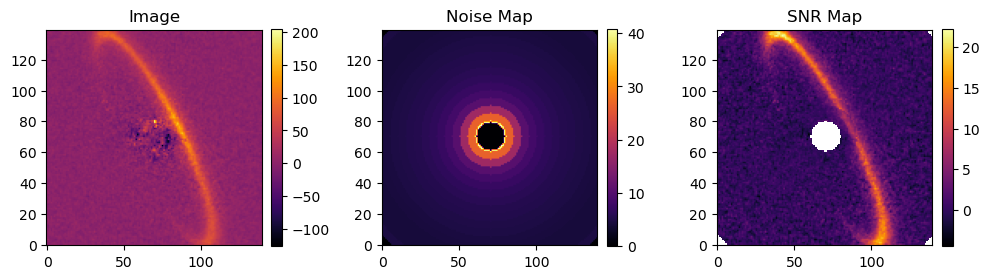

In [35]:
fits_image_filepath = "Fits/hr4796a_H_pol.fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
image = process_image(hdul['SCI'].data[1,:,:])

# Noise map 
mask_radius = 9
mask = np.ones_like(image)
y,x = np.indices(image.shape)
y -= image.shape[0]//2
x -= image.shape[1]//2
radii = np.sqrt(x**2 + y**2)
mask[radii <= mask_radius] = 0
noise_map = create_empirical_err_map(process_image(hdul['SCI'].data[2,:,:]))


# Displays Image
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

im = axes[0].imshow(image, origin='lower', cmap='inferno')
axes[0].set_title('Image')
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

im = axes[1].imshow(noise_map, origin='lower', cmap='inferno')
axes[1].set_title('Noise Map')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

im = axes[2].imshow(image/noise_map, origin='lower', cmap='inferno')
axes[2].set_title('SNR Map')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()


## Define some functions and do a first fit

In [36]:
from disk_utils_jax import jax_model_all_1d, jax_model
from regression import log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize
from SLD_utils import *

In [37]:
def get_initial_guess_params(inclination,radius, position_angle, mask, distance, num_knots = 6, knot_scale = None, 
                             target_image = None, full=True, psf_model=EMP_PSF): 

    ##############################################################
    #### Generate a first image to help get the scaling right ####
    ##############################################################

    #Hack in this starting guess for SPF. Force the radius to make it 6 knots. 
    knots = get_inc_bounded_knots(inclination, num_knots, buffer = 0)
    #This is based off an older disk fit - Does alright! 
    # init_knot_guess = jnp.array([2.75100528e-04, 2.62405787e-04,2.50897081e-04, 2.40426582e-04,  2.30863915e-04, 2.22149277e-04])
    init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], knots)/ 1e4
    
    #alpha_in, alpha_out, 
    init_disk_guess = jnp.array([23., -13., radius, inclination, position_angle])
    init_cent_guess = jnp.array([68., 68.])
    init_guess = None

    if(full):
        image_fun = quick_image_full_opt
        #amin, ksi0, gamma, beta
        distr_guess = jnp.array([0, 3, 2, 1])
        init_guess = jnp.concatenate([init_disk_guess, init_cent_guess, distr_guess, init_knot_guess])
    else:
        image_fun = quick_image_cent
        init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

    ###########################
    ##### Scale the knots #####
    ###########################
    if knot_scale is None:
        if target_image is None: 
            raise ValueError("If you don't provide a knot scale, you need to provide a target image to scale to.")
        init_image = image_fun(init_guess, PSFModel = psf_model, pxInArcsec=0.01414, distance = distance, knots=knots)
        if inclination > 70: 
            knot_scale = 1.*np.percentile(target_image[mask], 99) / jnp.nanmax(init_image)
        else: 
            knot_scale = 0.2*np.percentile(target_image[mask], 99) / jnp.nanmax(init_image)

    init_knot_guess = init_knot_guess * knot_scale
    if(full):
        init_guess = jnp.concatenate([init_disk_guess, init_cent_guess, distr_guess, init_knot_guess])
    else:
        init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

    return init_guess

In [40]:
def plot_data_model_residuals(target_image, distance, params, knots = None, full = True): 

    #Get the initial guess image
    if full: 
        image_fun = quick_image_full_opt
    else: 
        image_fun = quick_image_cent

    init_image = image_fun(params, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = distance, knots = knots)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
    axes[0].set_title('Target Image')
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    im = axes[1].imshow(init_image, origin='lower', cmap='inferno')
    axes[1].set_title('Model Image')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    im = axes[2].imshow(target_image-init_image, origin='lower', cmap='inferno')
    axes[2].set_title('Residuals')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.show()

[ 23.         -13.          78.5         76.5         26.1
  68.          68.           0.           3.           2.
   1.         979.18074482 412.90652073 239.53209161 160.78032909
 117.37806126  90.5093132   72.52780219  59.80098072  50.40490726
  43.23526405]


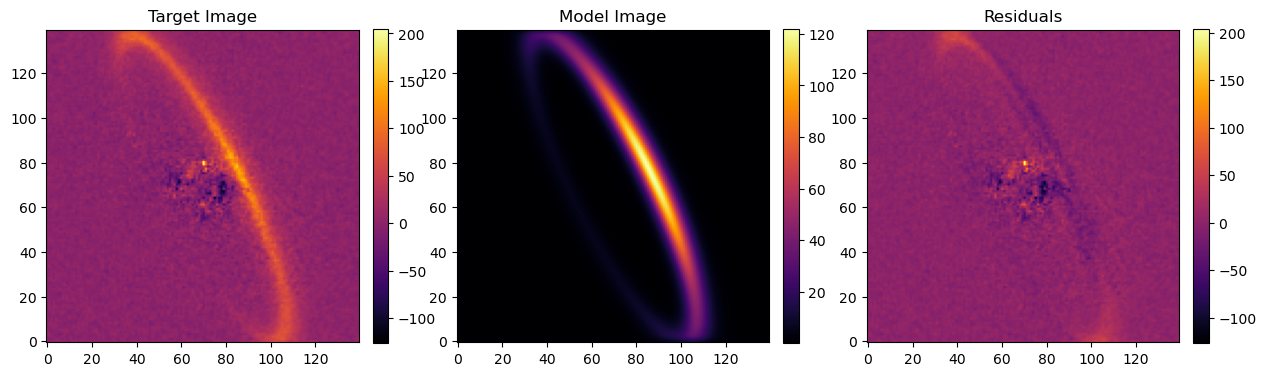

In [42]:
num_knots = 10
# inclination,radius, position_angle, mask, distance, knot_scale = None, target_image = None, full=True): 
knots = get_inc_bounded_knots(image_data['Inclination'], num_knots, buffer = 0)

init_guess = get_initial_guess_params(image_data['Inclination'], 
                                      image_data['Radius'], 
                                      image_data['Position Angle'], 
                                     mask.astype(bool), 
                                     image_data['Distance'], num_knots = num_knots,
                                     target_image = image, full=True, 
                                     knot_scale=2.4e7)
print(init_guess)

plot_data_model_residuals(image, image_data['Distance'], init_guess, full = True, knots =knots)

## Do a fit now

In [43]:
##########################
##### Do the fit #####
##########################
full = True
if(full):
    opt_fun = quick_optimize_full_opt
    image_fun = quick_image_full_opt
else:
    opt_fun = quick_optimize_cent
    image_fun = quick_image_cent

knots = get_inc_bounded_knots(image_data['Inclination'], num_knots, buffer = 0  )

print("Starting optimization")
start = datetime.now()
soln = opt_fun(image, noise_map, init_guess=init_guess, method = 'Nelder-Mead', 
               iters = 10000, PSFModel=EMP_PSF, pxInArcsec=0.01414, 
               distance = image_data['Distance'], 
               knots = knots, full_soln=True, disp=False)
end = datetime.now()
print("Time taken: " + str(end-start))

print(soln.message)
cent_image = image_fun(soln.x, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = image_data['Distance'], knots=knots)

Starting optimization
Time taken: 0:02:05.567609
Maximum number of iterations has been exceeded.


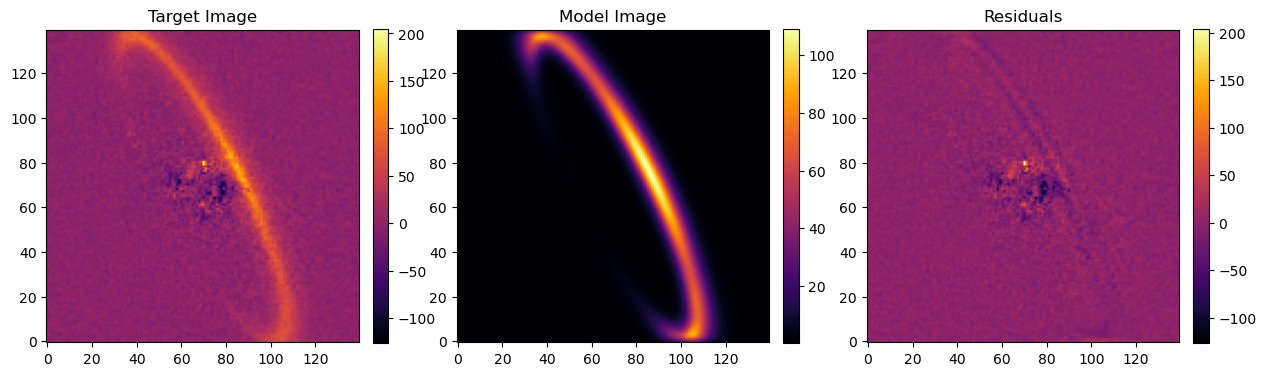

In [45]:
plot_data_model_residuals(image, image_data['Distance'], soln.x, full = full, knots=knots)

### Go back to other optimization method and see if it improves things: 

Starting optimization
Time taken: 0:00:14.965733
Maximum number of iterations has been exceeded.


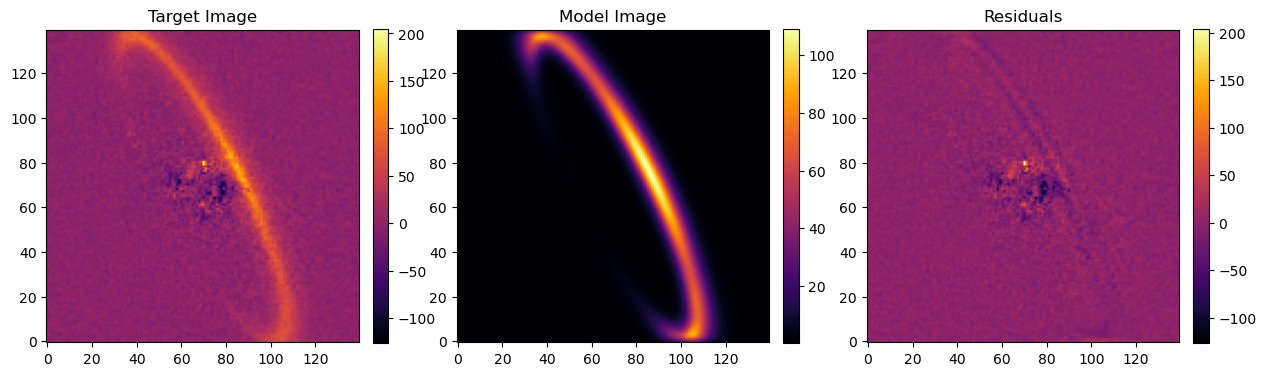

In [46]:
print("Starting optimization")
start = datetime.now()
soln_3 = opt_fun(image, noise_map, init_guess=jnp.array(soln.x),  
               iters = 10000, PSFModel=EMP_PSF, pxInArcsec=0.01414, 
               distance = image_data['Distance'], 
               knots = knots, full_soln=True, disp=False)

end = datetime.now()
print("Time taken: " + str(end-start))

print(soln.message)
cent_image = image_fun(soln_3.x, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = image_data['Distance'], knots=knots)

plot_data_model_residuals(image, image_data['Distance'], soln_3.x, full = full,knots=knots)

Starting optimization
Time taken: 0:01:29.927726
Maximum number of iterations has been exceeded.


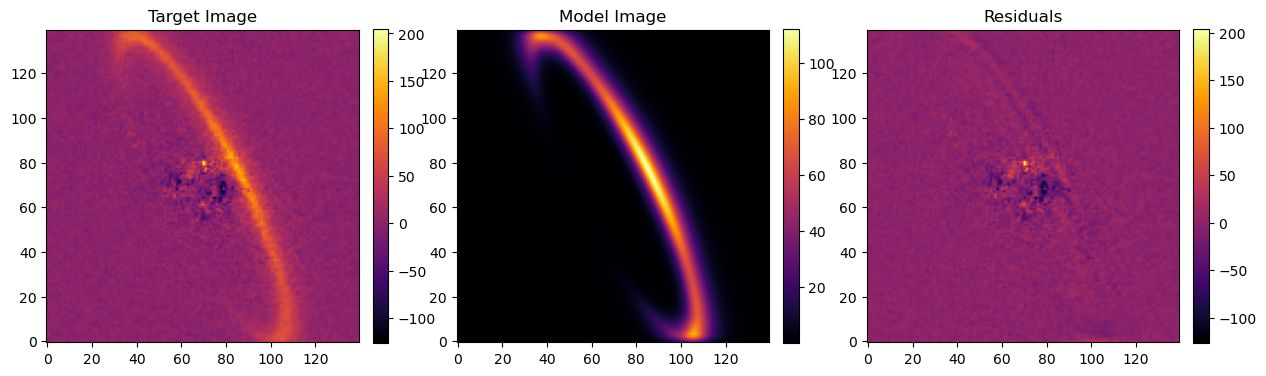

In [47]:
print("Starting optimization")
start = datetime.now()
soln_4 = opt_fun(image, noise_map, init_guess=jnp.array(soln_3.x),  method='Nelder-Mead',
               iters = 10000, PSFModel=EMP_PSF, pxInArcsec=0.01414, 
               distance = image_data['Distance'], 
               knots = knots, full_soln=True, disp=False)

end = datetime.now()
print("Time taken: " + str(end-start))

print(soln.message)
cent_image = image_fun(soln_4.x, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = image_data['Distance'], knots=knots)

plot_data_model_residuals(image, image_data['Distance'], soln_4.x, full = full,knots=knots)

That method swap looks like it helped a bit. What if I did it one more time

Starting optimization
Time taken: 0:00:18.237982
Time taken: 0:02:04.964458
Maximum number of iterations has been exceeded.


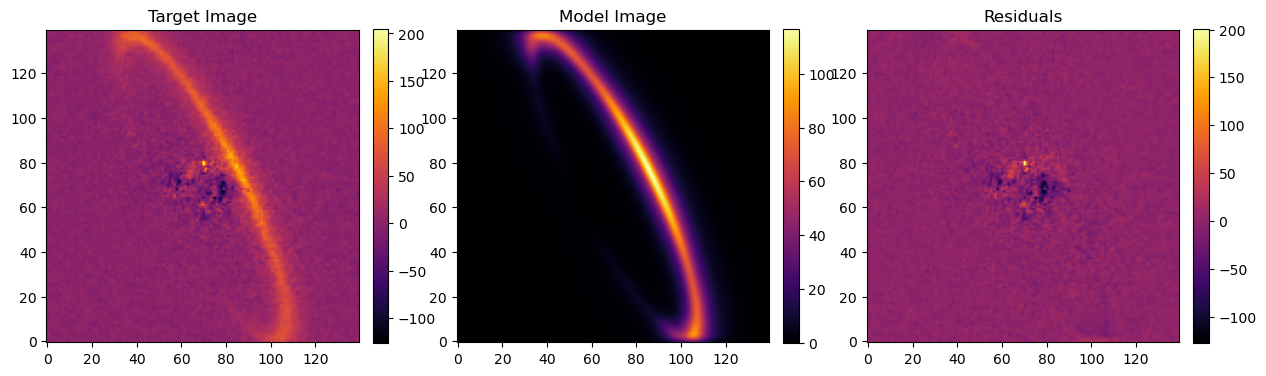

In [48]:
print("Starting optimization")
start = datetime.now()
soln_3 = opt_fun(image, noise_map, init_guess=jnp.array(soln_4.x),  
               iters = 10000, PSFModel=EMP_PSF, pxInArcsec=0.01414, 
               distance = image_data['Distance'], 
               knots = knots, full_soln=True, disp=False)

end = datetime.now()
print("Time taken: " + str(end-start))

soln_4 = opt_fun(image, noise_map, init_guess=jnp.array(soln_3.x),  method='Nelder-Mead',
               iters = 10000, PSFModel=EMP_PSF, pxInArcsec=0.01414, 
               distance = image_data['Distance'], 
               knots = knots, full_soln=True, disp=False)

end = datetime.now()
print("Time taken: " + str(end-start))

print(soln.message)
cent_image = image_fun(soln_4.x, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = image_data['Distance'], knots=knots)

plot_data_model_residuals(image, image_data['Distance'], soln_4.x, full = full,knots=knots)


In [49]:
soln_4.x

array([ 4.71198543e+00, -3.00777810e+01,  7.89019835e+01,  7.64810121e+01,
        2.66713609e+01,  6.86469575e+01,  6.81480415e+01, -2.29592347e-24,
        1.74177068e+00,  1.10094316e+00,  2.03601874e+01,  1.66889138e+03,
        8.24739726e+02,  6.87664489e+02,  5.28639083e+02,  5.61680173e+02,
        3.36329019e+02,  3.57486292e+02,  1.21496721e+02,  8.11969326e+01,
       -3.19780692e+00])

I think this is better than with 6 knots

## Swap PSFs

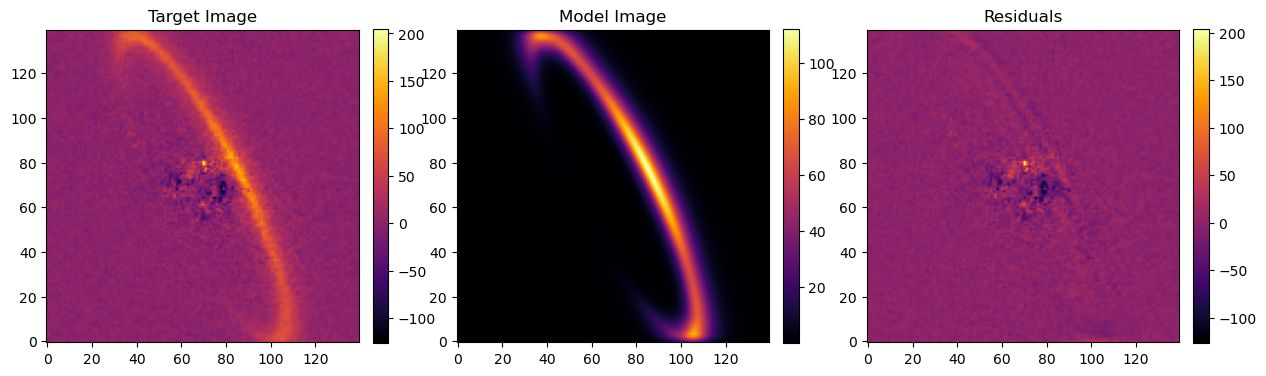

In [51]:
cent_image = image_fun(soln_3.x, PSFModel = GAUSSIAN_PSF, pxInArcsec=0.01414, distance = image_data['Distance'], knots=knots)

plot_data_model_residuals(image, image_data['Distance'], soln_3.x, full = full,knots=knots)

That doesn't do much